In [82]:
from keras.layers import Input,Dense,LeakyReLU,Conv2D,Conv2DTranspose,Reshape,Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras.optimizers import Adam

In [83]:
#Generator

latent_dim = 32
height = 32
width = 32
channels = 3
img_row_shape = 16
img_col_shape = 16
img_channel_num = 128 # 
channels = 3

In [84]:
generator_input = Input(shape=(latent_dim,))
x = Dense(img_channel_num * img_row_shape * img_col_shape)(generator_input)
x = LeakyReLU()(x)
x = Reshape((img_row_shape,img_col_shape,img_channel_num))(x)

x = Conv2D(256,5, padding= 'same')(x)
x = LeakyReLU()(x)

x = Conv2DTranspose(256,4, strides = 2, padding='same')(x)
x = LeakyReLU()(x)

x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)
x = Conv2D(256, 5, padding = 'same')(x)
x = LeakyReLU()(x)

x = Conv2D(channels, 7 , activation = 'tanh',padding = 'same')(x)
generator = Model(generator_input,x)

In [85]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [86]:
discriminator_input = Input(shape = (width,height,channels))
x = Conv2D(128,3)(discriminator_input)
x = LeakyReLU()(x)

x = Conv2D(128,4, strides = 2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4, strides = 2)(x)
x = LeakyReLU()(x)
x = Conv2D(128,4, strides = 2)(x)
x = LeakyReLU()(x)
x = Flatten()(x)

x = Dropout(0.4)(x)
x = Dense(1,activation = 'sigmoid')(x)
discriminator = Model(discriminator_input,x)
discriminator_optimizer = RMSprop(lr = 0.0002,clipvalue = 1.0, decay = 1e-8)
discriminator.compile(optimizer = discriminator_optimizer, loss = 'binary_crossentropy')

In [87]:
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input)) #ganerator
gan = Model(gan_input, gan_output)

In [88]:
gan_optimizer = RMSprop(lr=0.0002,clipvalue=1.0,decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [89]:
from keras.datasets import cifar10
from keras.preprocessing import image
import os
import numpy as np
import glob

In [91]:
(x_train,y_train),(_,_) = cifar10.load_data()
x_train = x_train[y_train.flatten()==6]
x_train = x_train.reshape((x_train.shape[0],) + \
                         (width,height,channels)).astype('float32')/255.

In [92]:

iterations = 10000
batch_size = 20
save_dir = "./frog/"

In [93]:
start = 0 
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = x_train[start : stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size,1)),\
                            np.zeros((batch_size,1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    random_latent_vectors = np.random.normal(size = (batch_size, latent_dim))
    
    misleading_targets = np.zeros((batch_size,1))
    
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    print("step : ", step)
    print("d_loss",d_loss)
    print("a_loss",a_loss)
    start += batch_size 
    if start > len(x_train) - batch_size : 
        start =0
    if step % 10 == 0 :
        gan.save_weights("gan.h5")
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,'generated_frog'+str(step)+".png"))
        
        img = image.array_to_img(real_images[0]*255.,scale=False)
        img.save(os.path.join(save_dir,'real_frog'+str(step)+".png"))

C:\Users\ie-02\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step :  0
d_loss 0.69322187
a_loss 0.68189275
step :  1
d_loss 0.95458853
a_loss 0.686425
step :  2
d_loss 0.7030105
a_loss 1.105202
step :  3
d_loss 0.7478435
a_loss 0.74288595
step :  4
d_loss 0.70144236
a_loss 0.69450265
step :  5
d_loss 0.6631601
a_loss 0.61311543
step :  6
d_loss 0.9632038
a_loss 0.8015507
step :  7
d_loss 0.6754815
a_loss 0.95023406
step :  8
d_loss 0.730112
a_loss 0.7270125
step :  9
d_loss 0.72096056
a_loss 0.7393047
step :  10
d_loss 0.66884196
a_loss 0.6951211
step :  11
d_loss 0.64383936
a_loss 0.657067
step :  12
d_loss 0.7228395
a_loss 0.6442342
step :  13
d_loss 0.7709808
a_loss 0.97369576
step :  14
d_loss 0.6504017
a_loss 1.3812304
step :  15
d_loss 0.7676292
a_loss 0.736438
step :  16
d_loss 0.7156118
a_loss 0.6888987
step :  17
d_loss 0.6492737
a_loss 0.6461959
step :  18
d_loss 0.6949375
a_loss 0.6278658
step :  19
d_loss 0.7605341
a_loss 0.9093114
step :  20
d_loss 0.6746925
a_loss 0.76617944
step :  21
d_loss 0.6987909
a_loss 0.6762173
step :  22
d

step :  179
d_loss 1.330062
a_loss 1.5066023
step :  180
d_loss 1.6709007
a_loss 0.0910425
step :  181
d_loss 1.8235295
a_loss 0.24747822
step :  182
d_loss 1.1330538
a_loss 0.7855701
step :  183
d_loss 1.1382055
a_loss 0.045762062
step :  184
d_loss 2.2863827
a_loss 0.45409274
step :  185
d_loss 1.5114813
a_loss 0.12609346
step :  186
d_loss 2.250484
a_loss 4.0958395
step :  187
d_loss 5.2505307
a_loss 0.13764007
step :  188
d_loss 2.3108432
a_loss 0.17404574
step :  189
d_loss 1.7047154
a_loss 2.7697742
step :  190
d_loss 4.1864977
a_loss 0.16017486
step :  191
d_loss 1.3759648
a_loss 0.20644799
step :  192
d_loss 1.4145163
a_loss 0.31277746
step :  193
d_loss 1.3927205
a_loss 0.260949
step :  194
d_loss 1.6664807
a_loss 0.86240256
step :  195
d_loss 1.6986492
a_loss 0.13060899
step :  196
d_loss 1.6860063
a_loss 0.26846984
step :  197
d_loss 1.3478934
a_loss 1.4319645
step :  198
d_loss 3.9238155
a_loss 0.048028313
step :  199
d_loss 2.2828414
a_loss 0.13607141
step :  200
d_loss 1.

KeyboardInterrupt: 

In [107]:
np.random.randint(0, 10, 20)

array([4, 9, 7, 2, 5, 3, 6, 5, 5, 0, 7, 6, 7, 2, 0, 4, 6, 3, 5, 2])

In [126]:
class LSGAN():
    def __init__(self):
        self.latent_dim = 32
        self.img_channel_num = 128 #generator 에서 생성될 channel num
        self.img_row_shape = 16 #generator 에서 생성될 row
        self.img_col_shape = 16 #generator 에서 생성될 col
        self.output_channels = 3 #generator 에서 나올 channels 당연히 3
        
        self.row = 32 #discriminator에 들어갈 row shape = generator의 output
        self.col = 32 #discriminator에 들어갈 col shape
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        self.discriminator_optimizer = Adam(lr=0.0002)
        self.gan_optimizer = Adam(lr =0.0002)
        self.discriminator.compile(loss = 'mse', optimizer = self.discriminator_optimizer,\
                                  metrics = ['accuracy'])
        
        self.discriminator.trainable = False
        
        gan_input = Input(shape=(self.latent_dim,))
        gan_output = self.discriminator(self.generator(gan_input))
        self.gan = Model(gan_input,gan_output)
        self.gan.compile(loss = 'mse',optimizer = self.gan_optimizer)
        
    def build_generator(self):
        generator_input = Input(shape=(self.latent_dim,))
        x = Dense(self.img_channel_num * self.img_row_shape * self.img_col_shape)(generator_input)
        x = LeakyReLU()(x)            
        x = Reshape((self.img_row_shape,self.img_col_shape,self.img_channel_num))(x)

        x = Conv2D(256,5, padding= 'same')(x)
        x = LeakyReLU()(x)

        x = Conv2DTranspose(256,4, strides = 2, padding='same')(x)
        x = LeakyReLU()(x)

        x = Conv2D(256, 5, padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Conv2D(256, 5, padding = 'same')(x)
        x = LeakyReLU()(x)
        x = Conv2D(self.output_channels, 7 , activation = 'tanh',padding = 'same')(x)
        generator = Model(generator_input,x)
        return generator
    
    def build_discriminator(self):
        discriminator_input = Input(shape = (self.row,self.col,self.output_channels))
        x = Conv2D(128,3)(discriminator_input)
        x = LeakyReLU()(x)

        x = Conv2D(128,4, strides = 2)(x)
        x = LeakyReLU()(x)
        x = Conv2D(128,4, strides = 2)(x)
        x = LeakyReLU()(x)
        x = Conv2D(128,4, strides = 2)(x)
        x = LeakyReLU()(x)
        x = Flatten()(x)

        x = Dropout(0.4)(x)
        x = Dense(1,activation = 'sigmoid')(x)
        discriminator = Model(discriminator_input,x)
        return discriminator
        
    def train(self, X_train,epochs, batch_size=128, sample_interval=50,save_dir = "./lsgan_frog/"):

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        valid += 0.05 * np.random.random(valid.shape)
        fake = np.zeros((batch_size, 1))
        fake += 0.05 * np.random.random(fake.shape)
        start = 0
        for step in range(iterations):
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_images = self.generator.predict(noise)
            stop = start + batch_size
            real_images = X_train[start : stop]
            #combined_images = np.concatenate([generated_images, real_images])
            #combined_labels = np.concatenate([fake,valid])
            #combined_labels += 0.05 * np.random.random(combined_labels.shape)
            
            d_loss_real = self.discriminator.train_on_batch(real_images, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_images, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            
            g_loss = self.gan.train_on_batch(noise, valid)
            
            print("step : ", step)
            print("d_loss",d_loss)
            print("d_loss_real",d_loss_real)
            print("d_loss_fake",d_loss_fake)
            print("g_loss",g_loss)
            start += batch_size 
            if start > len(x_train) - batch_size : 
                start =0
            if step % 10 == 0 :
                gan.save_weights("lsgan.h5")
                img = image.array_to_img((generated_images[0] * 127.5)+127.5, scale=False)
                img.save(os.path.join(save_dir,'generated_frog_'+str(step)+".png"))

                img = image.array_to_img((real_images[0] * 127.5) + 127.5,scale=False)
                img.save(os.path.join(save_dir,'real_frog_'+str(step)+".png"))


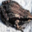

In [122]:
image.array_to_img(x_train[5]*255,scale=False)

In [127]:
model = LSGAN()

In [128]:
(x_train,y_train),(_,_) = cifar10.load_data()
x_train = x_train[y_train.flatten()==6]
x_train = x_train.reshape((x_train.shape[0],) + \
                         (width,height,channels)).astype('float32')

In [ ]:
model.train(x_train,epochs = 10)

C:\Users\ie-02\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


step :  0
d_loss [0.24976125 0.        ]
d_loss_real [0.27296102, 0.0]
d_loss_fake [0.2265615, 0.0]
g_loss 0.27339375
step :  1
d_loss [0.2063446 0.       ]
d_loss_real [0.17054757, 0.0]
d_loss_fake [0.24214165, 0.0]
g_loss 0.25287193
step :  2
d_loss [0.21727777 0.        ]
d_loss_real [0.09385974, 0.0]
d_loss_fake [0.3406958, 0.0]
g_loss 0.17471339
step :  3
d_loss [0.3230943 0.       ]
d_loss_real [0.052498315, 0.0]
d_loss_fake [0.5936903, 0.0]
g_loss 0.07352994
step :  4
d_loss [0.390272 0.      ]
d_loss_real [0.03942565, 0.0]
d_loss_fake [0.7411183, 0.0]
g_loss 0.0475699
step :  5
d_loss [0.3803041 0.       ]
d_loss_real [0.04680335, 0.0]
d_loss_fake [0.71380484, 0.0]
g_loss 0.07615239
step :  6
d_loss [0.29621056 0.        ]
d_loss_real [0.06622911, 0.0]
d_loss_fake [0.526192, 0.0]
g_loss 0.22623888
step :  7
d_loss [0.13002266 0.        ]
d_loss_real [0.10994684, 0.0]
d_loss_fake [0.15009847, 0.0]
g_loss 0.58909345
step :  8
d_loss [0.0966242 0.       ]
d_loss_real [0.16927621, 